In [7]:
!pip install lightgbm==3.1.1

In [8]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/distan_lat42.22lon-8.63p2R1Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [9]:
#@title Load station. Load meteorological model forecast D0.
def datetime_one_hour_after_rounded(dt):
    # Round down to the nearest hour
    rounded_down = dt.replace(minute=0, second=0, microsecond=0)
    # Add one hour
    return rounded_down + pd.Timedelta(hours=1)


observed_var = ["time","visibility_o","tempd_o","temp_o","spd_o",]
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/LEVXY2018Y2022.csv",
                          usecols = observed_var,
                          parse_dates=["time"]).dropna().set_index("time")


#Load meteorological model
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")
model_var = ["visibility1","cft1","prec1","dir1","mod1","rh1","cfl1","wind_gust1"]

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model[model_var]],axis=1).dropna()

# Apply the function to create the new column  speci
index_not_hourly_half_hourly = station[(station.index.minute != 0) & (station.index.minute != 30)].index
index_not_hourly_half_hourly_round_hour_after = index_not_hourly_half_hourly.to_series().apply(datetime_one_hour_after_rounded)
df_all["speci"] = ["y" if t in index_not_hourly_half_hourly_round_hour_after.values else "n" for t in df_all.index]
df_all.speci.value_counts(normalize=True).transform(lambda x: '{:,.0%}'.format(x))




speci
n    94%
y     6%
Name: proportion, dtype: object

Round 0


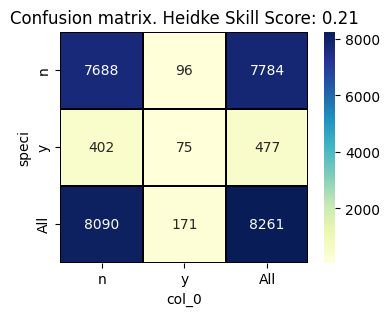

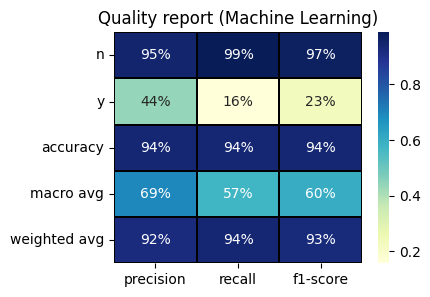

,feature,feature_per
0,temp_o,13.0%
2,spd_o,12.6%
1,tempd_o,11.5%
7,dir1,7.3%
4,visibility1,6.7%
14,dayofyear,6.6%
9,rh1,6.2%
3,visibility_o,6.0%
12,hour,5.4%
11,wind_gust1,4.9%


Round 1


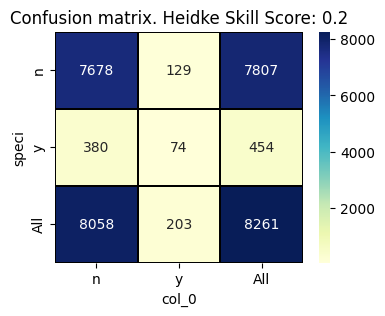

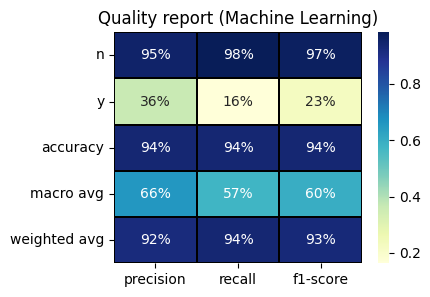

,feature,feature_per
0,temp_o,12.3%
2,spd_o,12.0%
1,tempd_o,11.7%
7,dir1,7.6%
9,rh1,6.9%
3,visibility_o,6.4%
4,visibility1,6.4%
14,dayofyear,6.4%
12,hour,5.7%
11,wind_gust1,4.8%


Round 2


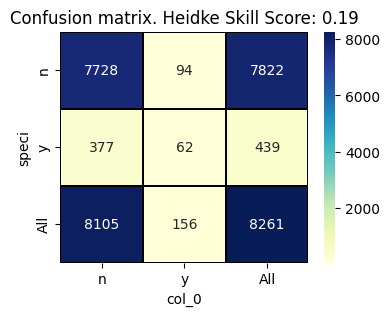

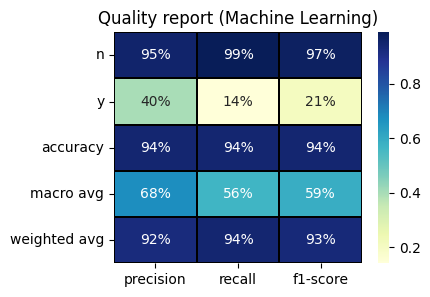

,feature,feature_per
2,spd_o,12.4%
0,temp_o,11.5%
1,tempd_o,10.9%
7,dir1,7.8%
4,visibility1,7.0%
9,rh1,6.8%
14,dayofyear,6.6%
3,visibility_o,6.0%
12,hour,5.5%
8,mod1,4.8%



HSS stadistics
            HSS
count  3.000000
mean   0.197023
std    0.010841
min    0.185713
25%    0.191872
50%    0.198030
75%    0.202678
max    0.207325
Shapiro test normality
p value: 0.8460950382506958
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 6.107273296101977e-82
Significance level: 0.01
Degres of of freedom:  1
Stadistic 367.6409015012123
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 0.29 minutes


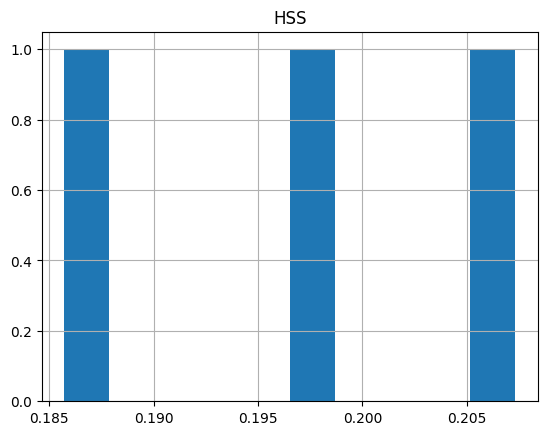

In [3]:
#@title ML LGBMClassifier. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.speci
X = df_all.drop(columns=["speci"])


# loop random
HSS = []
for t in range (0,3):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_res,y_res)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)
    #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [4]:
X.columns

Index(['temp_o', 'tempd_o', 'spd_o', 'visibility_o', 'visibility1', 'cft1',
       'prec1', 'dir1', 'mod1', 'rh1', 'cfl1', 'wind_gust1', 'hour', 'month',
       'dayofyear', 'weekofyear'],
      dtype='object')

In [5]:
station

,temp_o,tempd_o,spd_o,visibility_o
time,,,,
2018-01-01 00:00:00,281.0,280.0,3.601108,9994.0
2018-01-01 00:30:00,282.0,280.0,3.086664,9994.0
2018-01-01 01:00:00,282.0,280.0,4.115552,9994.0
2018-01-01 01:30:00,282.0,281.0,3.601108,9994.0
2018-01-01 02:00:00,282.0,281.0,4.115552,9994.0
...,...,...,...,...
2022-12-30 21:30:00,288.0,285.0,11.317768,9994.0
2022-12-30 22:00:00,288.0,285.0,8.231104,9994.0
2022-12-30 22:30:00,288.0,285.0,8.745548,9994.0


In [6]:
#@title Save last algorithm


x_var = X.columns
score = {"HSS_ml":HSS[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/speci_LEVX_d0.al", 'wb'))

Round 0


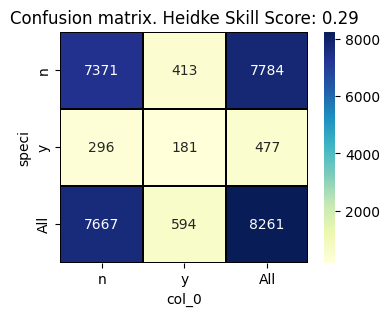

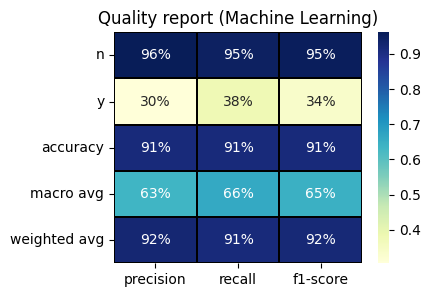

,feature,feature_per
3,visibility_o,19.2%
10,cfl1,17.2%
6,prec1,11.5%
5,cft1,7.0%
12,hour,5.2%
9,rh1,5.0%
0,temp_o,4.7%
2,spd_o,4.7%
4,visibility1,4.5%
7,dir1,4.2%


Round 1


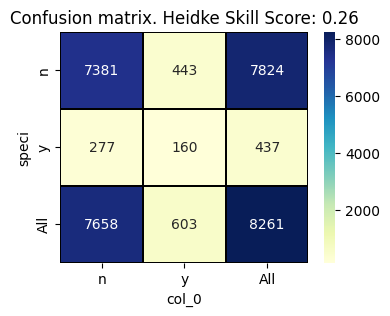

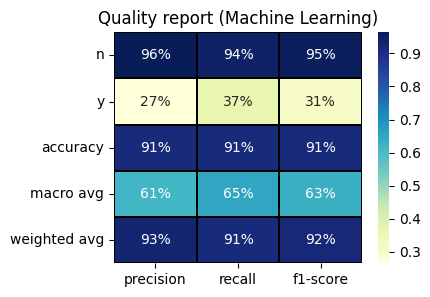

,feature,feature_per
3,visibility_o,16.8%
6,prec1,16.0%
10,cfl1,15.3%
5,cft1,6.1%
9,rh1,6.0%
0,temp_o,5.2%
12,hour,4.8%
4,visibility1,4.6%
2,spd_o,4.2%
7,dir1,4.1%


Round 2


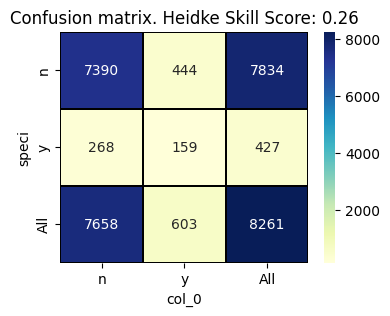

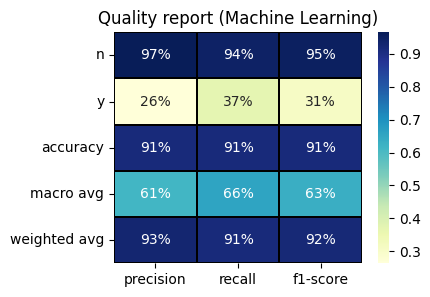

,feature,feature_per
3,visibility_o,20.6%
10,cfl1,15.5%
6,prec1,10.3%
5,cft1,6.2%
9,rh1,5.9%
12,hour,5.3%
0,temp_o,5.1%
4,visibility1,4.8%
2,spd_o,4.5%
7,dir1,4.2%



HSS stadistics
            HSS
count  3.000000
mean   0.273119
std    0.016981
min    0.262449
25%    0.263328
50%    0.264207
75%    0.278453
max    0.292700
Shapiro test normality
p value: 0.09891134147608949
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 1.050924204195309e-130
Significance level: 0.01
Degres of of freedom:  1
Stadistic 591.7347772763801
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 2.41 minutes


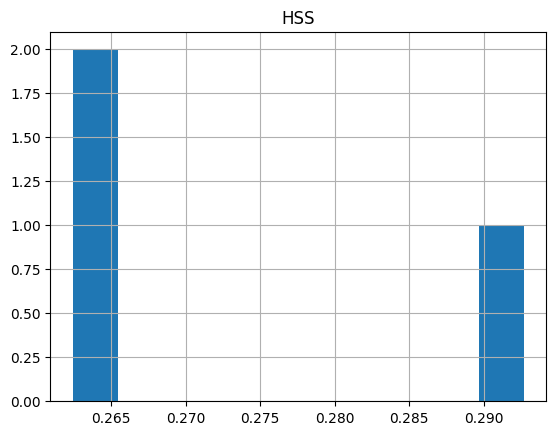

In [11]:
#@title ML RandomForestClassifier. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y



# loop random
HSS_E = []
for t in range (0,3):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  #ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")





